In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
from jcopdl.layers import linear_block

# Dataset and Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
batch_size = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform) 
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [8]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur dan Config

In [9]:
from jcopdl.layers import linear_block

In [10]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax"),
        )
        
    def forward(self, x):
        return self.fc(x)

In [11]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2,
})

# Training Preparation => MCOC

In [12]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [13]:
from tqdm.notebook import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7368 | Test_cost  = 0.4727 | Train_score = 0.7385 | Test_score = 0.8328 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.4757 | Test_cost  = 0.3998 | Train_score = 0.8330 | Test_score = 0.8547 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4235 | Test_cost  = 0.3656 | Train_score = 0.8500 | Test_score = 0.8660 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.3902 | Test_cost  = 0.3576 | Train_score = 0.8604 | Test_score = 0.8691 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.3679 | Test_cost  = 0.3615 | Train_score = 0.8690 | Test_score = 0.8663 |
==> EarlyStop patience =  1 | Best test_score: 0.8691


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3550 | Test_cost  = 0.3424 | Train_score = 0.8719 | Test_score = 0.8735 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3383 | Test_cost  = 0.3221 | Train_score = 0.8769 | Test_score = 0.8804 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3289 | Test_cost  = 0.3281 | Train_score = 0.8809 | Test_score = 0.8786 |
==> EarlyStop patience =  1 | Best test_score: 0.8804


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3155 | Test_cost  = 0.3259 | Train_score = 0.8851 | Test_score = 0.8792 |
==> EarlyStop patience =  2 | Best test_score: 0.8804


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3077 | Test_cost  = 0.3386 | Train_score = 0.8869 | Test_score = 0.8752 |
==> EarlyStop patience =  3 | Best test_score: 0.8804


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3015 | Test_cost  = 0.3198 | Train_score = 0.8902 | Test_score = 0.8798 |
==> EarlyStop patience =  4 | Best test_score: 0.8804


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2942 | Test_cost  = 0.3152 | Train_score = 0.8928 | Test_score = 0.8848 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2853 | Test_cost  = 0.3143 | Train_score = 0.8944 | Test_score = 0.8842 |
==> EarlyStop patience =  1 | Best test_score: 0.8848


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2817 | Test_cost  = 0.3064 | Train_score = 0.8958 | Test_score = 0.8868 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2744 | Test_cost  = 0.3108 | Train_score = 0.8989 | Test_score = 0.8860 |
==> EarlyStop patience =  1 | Best test_score: 0.8868


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2686 | Test_cost  = 0.3072 | Train_score = 0.9011 | Test_score = 0.8882 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2638 | Test_cost  = 0.3086 | Train_score = 0.9022 | Test_score = 0.8891 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2630 | Test_cost  = 0.3165 | Train_score = 0.9023 | Test_score = 0.8816 |
==> EarlyStop patience =  1 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2563 | Test_cost  = 0.3099 | Train_score = 0.9039 | Test_score = 0.8883 |
==> EarlyStop patience =  2 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2523 | Test_cost  = 0.3135 | Train_score = 0.9053 | Test_score = 0.8886 |


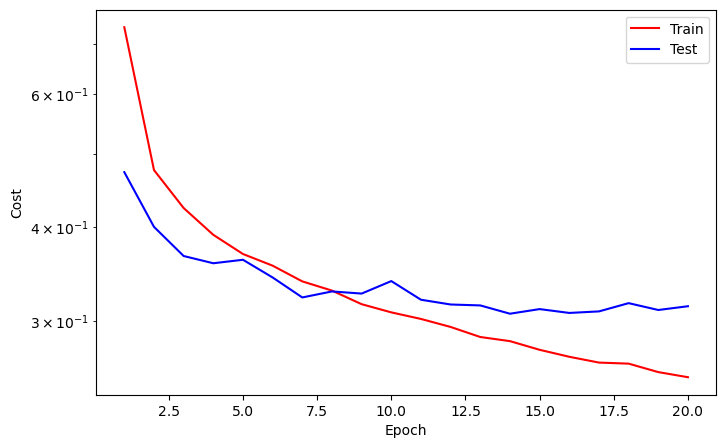

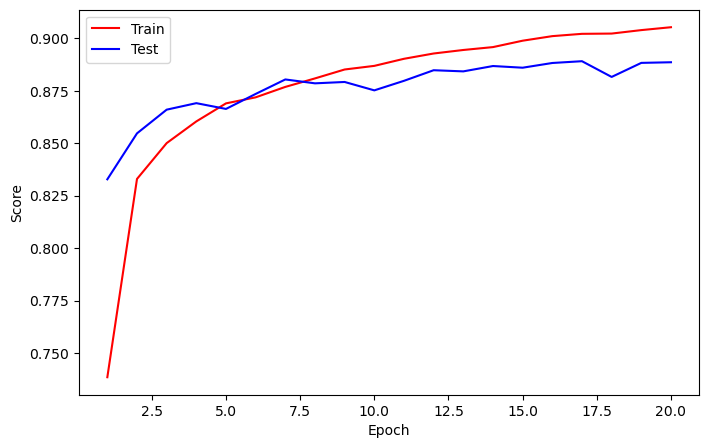

==> EarlyStop patience =  3 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2441 | Test_cost  = 0.3027 | Train_score = 0.9071 | Test_score = 0.8911 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2381 | Test_cost  = 0.3125 | Train_score = 0.9103 | Test_score = 0.8871 |
==> EarlyStop patience =  1 | Best test_score: 0.8911


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2387 | Test_cost  = 0.3012 | Train_score = 0.9104 | Test_score = 0.8927 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2339 | Test_cost  = 0.3063 | Train_score = 0.9117 | Test_score = 0.8908 |
==> EarlyStop patience =  1 | Best test_score: 0.8927


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2287 | Test_cost  = 0.3151 | Train_score = 0.9149 | Test_score = 0.8923 |
==> EarlyStop patience =  2 | Best test_score: 0.8927


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2280 | Test_cost  = 0.3015 | Train_score = 0.9154 | Test_score = 0.8922 |
==> EarlyStop patience =  3 | Best test_score: 0.8927


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2265 | Test_cost  = 0.3106 | Train_score = 0.9157 | Test_score = 0.8910 |
==> EarlyStop patience =  4 | Best test_score: 0.8927


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2181 | Test_cost  = 0.3152 | Train_score = 0.9189 | Test_score = 0.8915 |
==> EarlyStop patience =  5 | Best test_score: 0.8927
==> Execute Early Stopping at epoch: 28 | Best test_score: 0.8927
==> Best model is saved at model


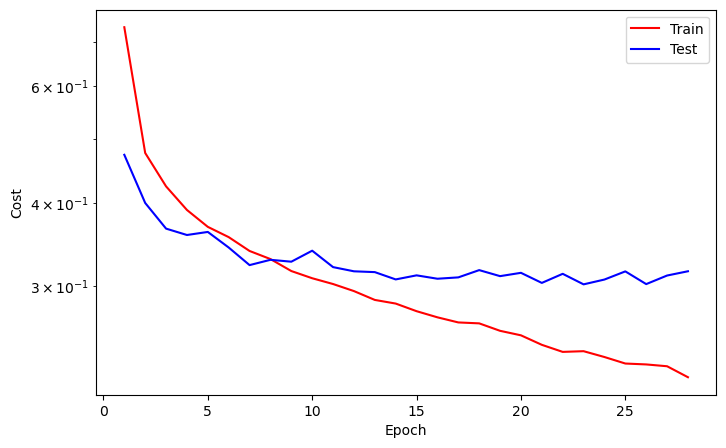

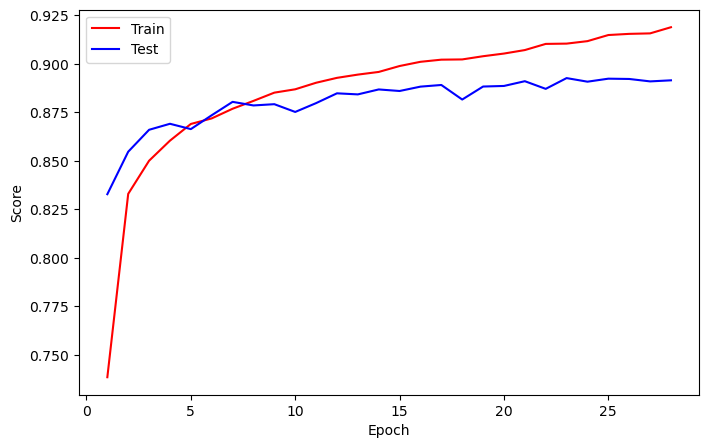

In [14]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Load best Model

In [26]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
model.load_state_dict(weights)
model = model.to(device)

In [15]:
model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=784, out_features=256, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (2): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=256, out_features=64, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (3): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=64, out_features=10, bias=True)
        (lsoftmax): LogSoftmax(dim=1)
      )
    )
  )
)

In [16]:
model.state_dict()

OrderedDict([('fc.1.block.linear.weight',
              tensor([[ 0.1416,  0.1051,  0.0681,  ...,  0.1313, -0.0927, -0.0066],
                      [ 0.2470,  0.2899, -0.0575,  ..., -0.2168,  0.0602,  0.0735],
                      [-0.3357, -0.0095, -0.1787,  ...,  0.0843,  0.0630,  0.3062],
                      ...,
                      [ 0.1062,  0.2969,  0.0791,  ...,  0.0247, -0.2261,  0.0533],
                      [ 0.2788,  0.3618,  0.2567,  ..., -0.0365,  0.0201,  0.2713],
                      [-0.0140,  0.0088,  0.0079,  ...,  0.0269,  0.0233, -0.0200]],
                     device='cuda:0')),
             ('fc.1.block.linear.bias',
              tensor([ 0.5577, -0.1726,  0.1720, -0.0308,  0.1706,  0.1708,  0.3839,  0.2099,
                      -0.2123, -0.0431, -0.0062,  0.1419, -0.1680, -0.0085,  0.4404, -0.0202,
                       0.4653, -0.0055,  0.1501, -0.1577,  0.1805,  0.0035,  0.2586,  0.1642,
                       0.1859, -0.3360, -0.1951,  0.3726, -0.140

# Predict

In [20]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [27]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred]for pred in preds]

['Dress',
 'Shirt',
 'Coat',
 'Trouser',
 'Sandal',
 'T-shirt or Top',
 'Ankle boot',
 'Coat',
 'Dress',
 'Trouser',
 'Trouser',
 'Sneaker',
 'Trouser',
 'Sandal',
 'Shirt',
 'Coat',
 'Dress',
 'Sneaker',
 'T-shirt or Top',
 'Pullover',
 'Sneaker',
 'Sandal',
 'Dress',
 'Sandal',
 'T-shirt or Top',
 'Bag',
 'Sneaker',
 'Sandal',
 'Shirt',
 'Sandal',
 'Ankle boot',
 'Ankle boot',
 'Sneaker',
 'Sneaker',
 'Sandal',
 'T-shirt or Top',
 'Sneaker',
 'T-shirt or Top',
 'Sandal',
 'Dress',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Sneaker',
 'Pullover',
 'T-shirt or Top',
 'Sneaker',
 'Bag',
 'T-shirt or Top',
 'Bag',
 'Sneaker',
 'Bag',
 'Bag',
 'Sandal',
 'Ankle boot',
 'T-shirt or Top',
 'Sneaker',
 'Coat',
 'Bag',
 'Sneaker',
 'Bag',
 'Sandal',
 'Ankle boot',
 'Sandal',
 'Shirt',
 'Sandal',
 'T-shirt or Top',
 'Coat',
 'Sandal',
 'Sneaker',
 'Sandal',
 'Coat',
 'Sandal',
 'Coat',
 'Sneaker',
 'Coat',
 'Ankle boot',
 'Pullover',
 'Dress',
 'Coat',
 'T-shirt or Top',
 'Trouser',
 'T-shirt 

# Visualisasi

In [23]:
import matplotlib.pyplot as plt

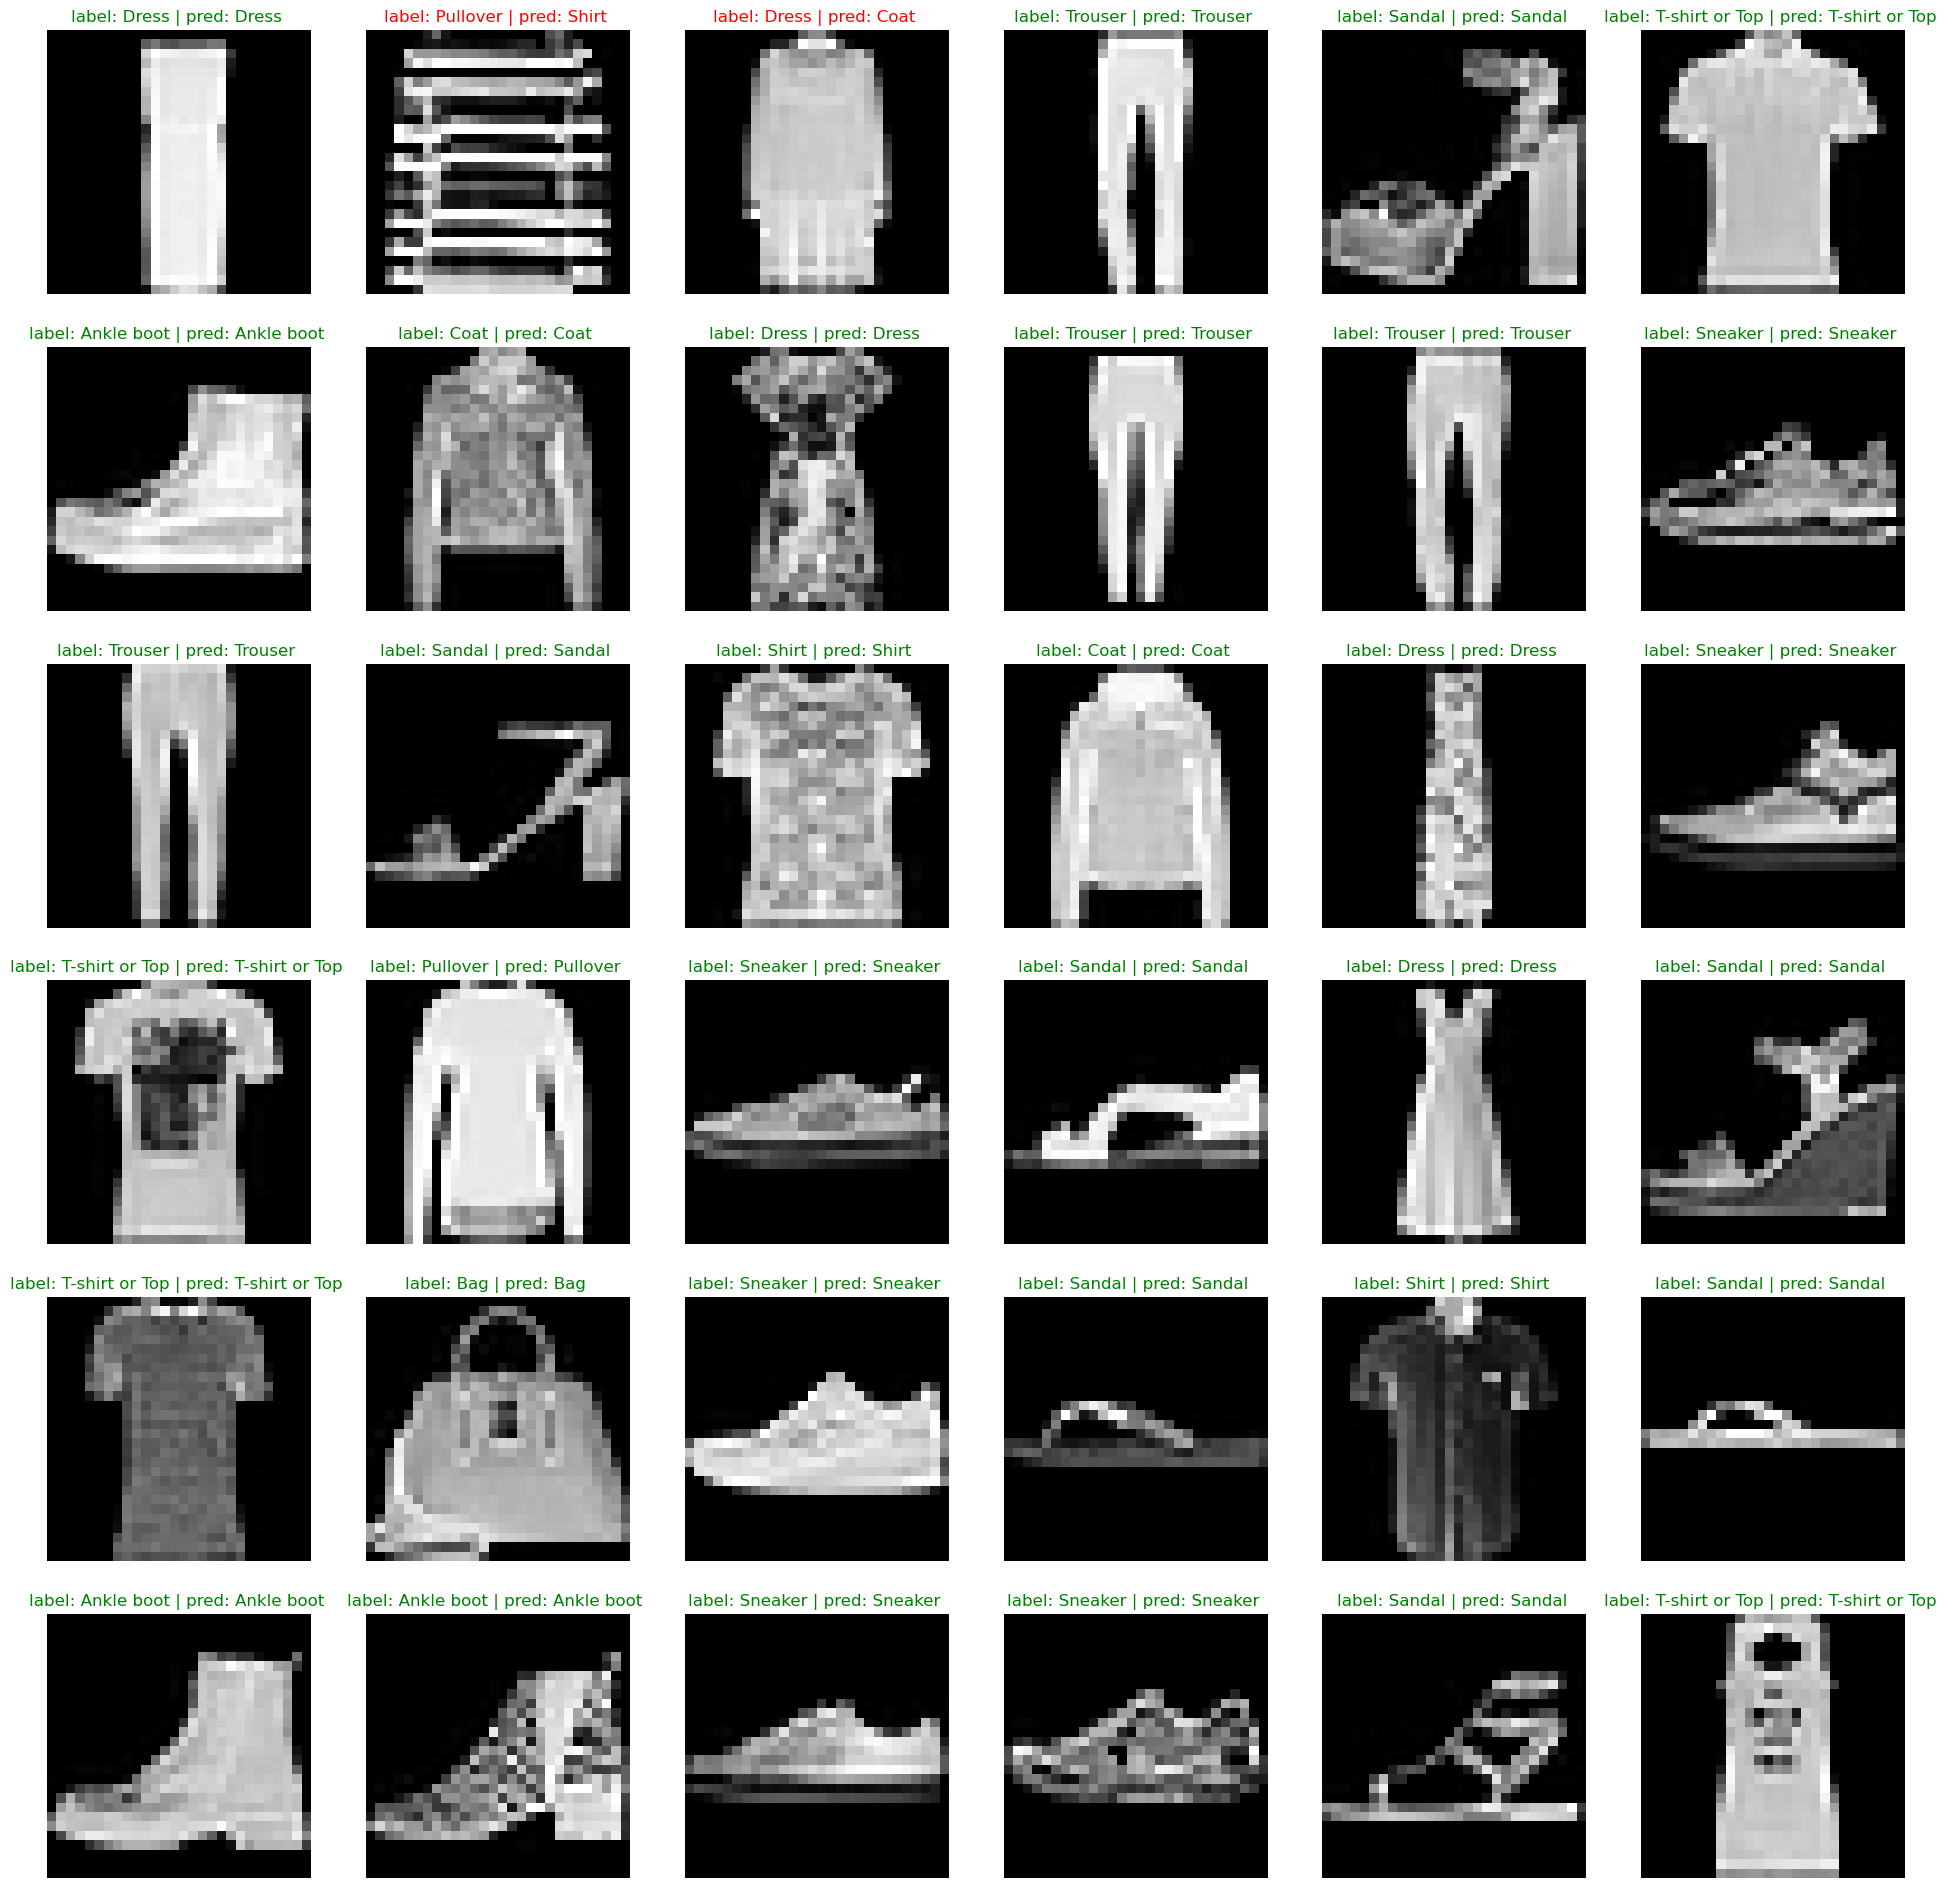

In [29]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"label: {label} | pred: {pred} ", fontdict=font);
    ax.axis('off');

In [14]:
from tqdm import tnrange, tqdm
from time import sleep

# example_iter = [1,2,3,4,5]
# for rec in tqdm_notebook(example_iter):
#     print(rec)

for i in tnrange(10, desc="1st loop"):
    for j in tqdm(range(100), desc='2nd lood'):
        sleep(0.001)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20488\3065139538.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10, desc="1st loop"):


1st loop:   0%|          | 0/10 [00:00<?, ?it/s]


2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 524.61it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 531.28it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 532.99it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.50it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 523.82it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 523.85it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 540.10it/s]

2nd lood: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 541.20it/s]

2nd lood: 100%|████████████████

In [18]:
from tqdm import trange, tqdm

for i in tqdm(range(100)):
    sleep(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


In [7]:

from rich.progress import track
from time import sleep
 
for step in track(range(15), total=10):
    sleep(1)

Output()

In [10]:
from rich.progress import track
from time import sleep

for step in track(range(15), description="Processing..."):
    sleep(1)

Output()

In [11]:
from tqdm import tqdm
from time import sleep

# Custom bar format
bar_format = "{l_bar}{bar} | Step: {n_fmt}/{total_fmt} | {remaining}"

for step in tqdm(range(15), desc="Processing...", bar_format=bar_format):
    sleep(1)

Processing...: 100%|█████████████████████████████████████████████████████████████████████████████ | Step: 15/15 | 00:00
